In [1]:
# importing libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# synthetic non-linear data with 3 variables
def create_synthetic_data(samples=1000):
    x1 = np.random.uniform(-5, 5, samples)
    x2 = np.random.uniform(-5, 5, samples)
    x3 = np.random.uniform(-5, 5, samples)

    # 3-variable nonlinear relationship
    y = (2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 +
         np.cos(x1 * x2) + np.random.normal(0, 0.2, samples))

    features = np.column_stack((x1, x2, x3))
    return torch.FloatTensor(features), torch.FloatTensor(y.reshape(-1, 1))

# generating training data
X_train, y_train = create_synthetic_data(1000)

In [3]:
# custom neural network from scratch
class SimpleNN:
    def __init__(self, input_dim, hidden1, hidden2, output_dim):
        self.W1 = torch.randn(input_dim, hidden1) * np.sqrt(2. / input_dim)
        self.b1 = torch.zeros(hidden1)

        self.W2 = torch.randn(hidden1, hidden2) * np.sqrt(2. / hidden1)
        self.b2 = torch.zeros(hidden2)

        self.W3 = torch.randn(hidden2, output_dim) * np.sqrt(2. / hidden2)
        self.b3 = torch.zeros(output_dim)

        # autograd enabled
        for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]:
            param.requires_grad_()

    def relu(self, x):
        return torch.maximum(torch.tensor(0.0), x)

    def forward(self, x):
        self.z1 = torch.mm(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = torch.mm(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = torch.mm(self.a2, self.W3) + self.b3
        return self.z3

    def get_params(self):
        return [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

    def zero_grad(self):
        for param in self.get_params():
            if param.grad is not None:
                param.grad.zero_()

In [4]:
def train_network(model, inputs, targets, lr=0.01, epochs=1000):
    losses = []

    for epoch in range(epochs):
        predictions = model.forward(inputs)
        loss = torch.mean((predictions - targets) ** 2)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.get_params():
                param -= lr * param.grad

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return losses

# initialize and train model
nn_model = SimpleNN(input_dim=3, hidden1=64, hidden2=32, output_dim=1)
loss_history = train_network(nn_model, X_train, y_train, lr=0.01, epochs=1000)

Epoch 0, Loss: 224.2200
Epoch 100, Loss: 106.6745
Epoch 200, Loss: 71.5189
Epoch 300, Loss: 111.6617
Epoch 400, Loss: 123.7606
Epoch 500, Loss: 55.3324
Epoch 600, Loss: 43.6658
Epoch 700, Loss: 90.5691
Epoch 800, Loss: 44.0612
Epoch 900, Loss: 80.8673


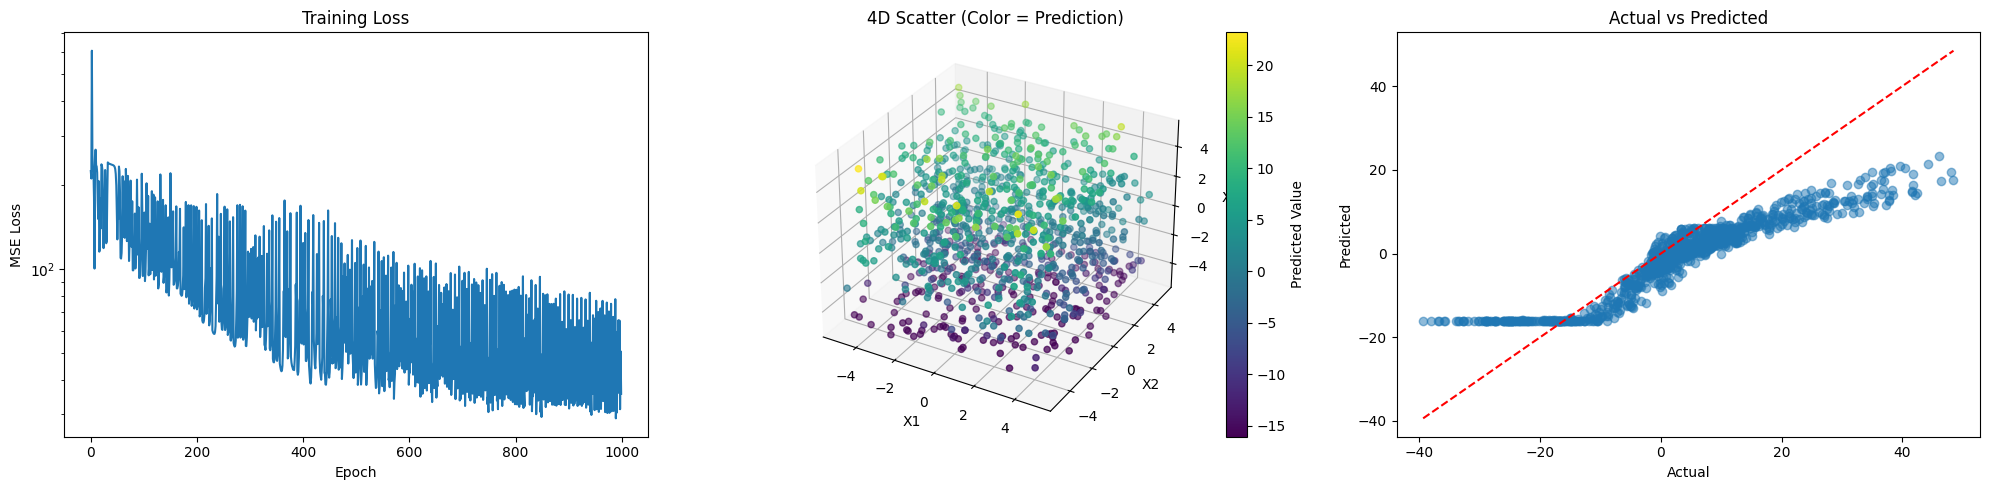

In [5]:
def visualize_results():
    fig = plt.figure(figsize=(20, 5))

    # loss over epochs
    ax1 = fig.add_subplot(131)
    ax1.plot(loss_history)
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("MSE Loss")
    ax1.set_yscale('log')

    # 4D scatter: x1, x2, x3 and color = predicted y
    ax2 = fig.add_subplot(132, projection='3d')
    with torch.no_grad():
        y_pred = nn_model.forward(X_train)

    scatter = ax2.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2],
                          c=y_pred.numpy(), cmap='viridis')
    plt.colorbar(scatter, ax=ax2, label='Predicted Value')
    ax2.set_xlabel("X1")
    ax2.set_ylabel("X2")
    ax2.set_zlabel("X3")
    ax2.set_title("4D Scatter (Color = Prediction)")

    # actual vs predicted
    ax3 = fig.add_subplot(133)
    ax3.scatter(y_train.numpy(), y_pred.numpy(), alpha=0.5)
    ax3.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    ax3.set_xlabel("Actual")
    ax3.set_ylabel("Predicted")
    ax3.set_title("Actual vs Predicted")

    plt.tight_layout()
    plt.show()

visualize_results()

In [7]:
def predict_new(model, x1, x2, x3):
    with torch.no_grad():
        sample = torch.FloatTensor([[x1, x2, x3]])
        return model.forward(sample).item()

# test samples
test_cases = [
    (-4, -4, -4),
    (-2, -2, -2),
    (0, 0, 0),
    (2, 2, 2),
    (4, 4, 4)
]

print(f"{'Input (x1, x2, x3)':<25} | {'Prediction':>12} | {'Actual':>12}")
print("-" * 55)
# loop through test cases
for x1, x2, x3 in test_cases:
    pred = predict_new(nn_model, x1, x2, x3)
    true_val = 2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2)
    print(f"({x1:>4}, {x2:>4}, {x3:>4})       | {pred:12.3f} | {true_val:12.3f}")

Input (x1, x2, x3)        |   Prediction |       Actual
-------------------------------------------------------
(  -4,   -4,   -4)       |      -16.090 |      -10.644
(  -2,   -2,   -2)       |       -3.000 |       -2.872
(   0,    0,    0)       |        1.184 |        1.000
(   2,    2,    2)       |        5.130 |        5.565
(   4,    4,    4)       |        8.132 |       24.729
